# Isoflow main notebook

In this notebook we showcase the main results achieved in the project, by sampling / generating data and evaluating it against train or test data.

### Loading libraries

In [4]:
import sys
import torch
import scanpy as sc
import anndata as ad

sys.path.append("../..")
from utils.autoencoder_utils import NB_Autoencoder 
#from autoencoder_utils import sample_nb

### Loading data

- Loading of test data

In [26]:
test_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train.h5ad"

# Test data
adata_test = sc.read_h5ad(test_path)

sc.pp.filter_genes(adata_test, min_cells=20) #remove genes with low count

adata_test.obs["dataset"] = "test"

- Loading of generated data before decoding

In [33]:
#Generated data before decoding
latent_path = "/dtu/blackhole/06/213542/paperdata/generated_latent.pt"

#Autoencoder model path
model_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_nb_autoencoder.pt"

#Training data path to extract var names from
adata_train = ad.read_h5ad("/dtu/blackhole/06/213542/paperdata/pbmc3k_train.h5ad")

#Path to save generated decoded cells in
gen_path = "/dtu/blackhole/06/213542/paperdata/generated_cfg_latents.h5ad"


- Loading of already decoded generated data

In [34]:
gen_path  = "/dtu/blackhole/06/213542/paperdata/generated_cells.h5ad" #"/dtu/blackhole/1e/213566/gen_data/pbmc3k/generated_counts_adata.h5ad"

adata_gen = sc.read_h5ad(gen_path)

sc.pp.filter_genes(adata_test, min_cells=20)

adata_gen.obs["dataset"] = "generated"

### Decode generated data if necessary (run previous cell once decoded)

Decoding

In [28]:
#Decode generated data

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters 
num_features = 8573  # number of genes/features
latent_dim = 50

# Instantiate the model
model = NB_Autoencoder(num_features=num_features, latent_dim=latent_dim)
model.to(device)

# Load trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # set to evaluation mode

z = torch.load(latent_path, map_location=device)  # shape should be (num_samples, 50)

# Make sure it's a float tensor
z = z.float()

In [31]:
with torch.no_grad():  # no gradient needed for inference
    decoded = model.decode(z, adata_train)

mu = decoded["mu"]        # expected counts
theta = decoded["theta"]  # dispersion
print(mu.shape, theta.shape)


torch.Size([500, 8573]) torch.Size([8573])


In [6]:
#theta, mu

In [32]:
#counts = sample_nb(mu, theta)

# Create AnnData object
adata_gen = ad.AnnData(X=counts.cpu().numpy())

# Assign gene names from test dataset
adata_gen.var_names = adata_train.var_names.copy()

# All generated cells are B cells
#adata_gen.obs["cell_type"] = "B cells"
adata_gen.obs["dataset"] = "generated"

sc.pp.filter_genes(adata_test, min_cells=20)

# Save the generated AnnData
adata_gen.write(gen_path)

print(f"Generated AnnData saved to {gen_path}")

NameError: name 'counts' is not defined

## Quantitative evaluation

In this notebook we will compare generated data to (held-out) real data by calculating MMD and 2-wassertein distance between first 30 PCs, projected using real data PC loadings.

In [15]:
#Compare generated data
from compute_metrics import compute_metrics

W1, W2, MMD = compute_metrics(test_path, gen_path, subsample=True)
print(W1, W2, MMD)

ModuleNotFoundError: No module named 'compute_metrics'

## Qualitative evaluation

### UMAPs

In [19]:
merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
# Preprocess
#sc.pp.normalize_total(merged_adata, target_sum=1e4)
#sc.pp.log1p(merged_adata)
#sc.pp.highly_variable_genes(merged_adata, flavor="seurat", n_top_genes=2000)
#merged_adata = merged_adata[:, merged_adata.var.highly_variable]
sc.pp.scale(merged_adata)

# PCA and neighbors
sc.tl.pca(merged_adata, svd_solver='arpack')
sc.pp.neighbors(merged_adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(merged_adata)

# Plot
sc.pl.umap(merged_adata, color="dataset", title="Generated vs Test Cells")


/tmp/ipykernel_3469894/1324159019.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
/appl9/python/3.11.9/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


InvalidParameterError: The 'n_components' parameter of PCA must be an int in the range [0, inf), a float in the range (0.0, 1.0), a str among {'mle'} or None. Got -1 instead.

### UMAP by cell type for conditional generation

In [9]:
#If needed, define the cell type
adata_gen.obs["cell_type"] = "B cells"

/tmp/ipykernel_2157882/2045288414.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
/appl9/python/3.12.9/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


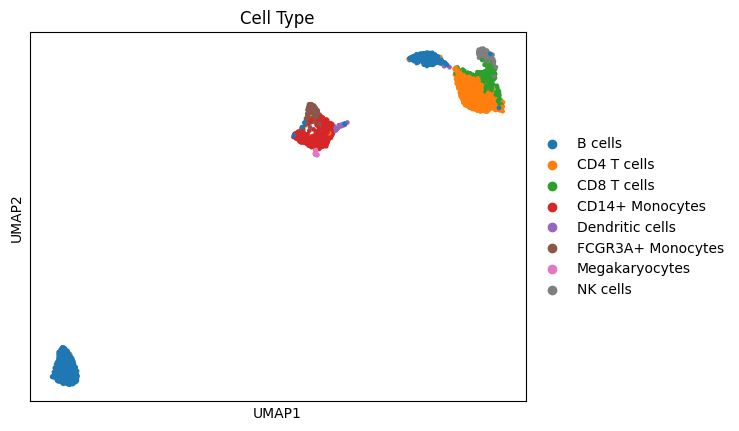

In [10]:
merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
# Preprocess
#sc.pp.normalize_total(merged_adata, target_sum=1e4)
#sc.pp.log1p(merged_adata)
#sc.pp.highly_variable_genes(merged_adata, flavor="seurat", n_top_genes=2000)
#merged_adata = merged_adata[:, merged_adata.var.highly_variable]
sc.pp.scale(merged_adata)

# PCA and neighbors
sc.tl.pca(merged_adata, svd_solver='arpack')
sc.pp.neighbors(merged_adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(merged_adata)

# Plot
sc.pl.umap(merged_adata, color="cell_type", title="Cell Type")


### Qualitative plots

In [37]:
sys.path.append("../..")
from utils import qual_eval_plots

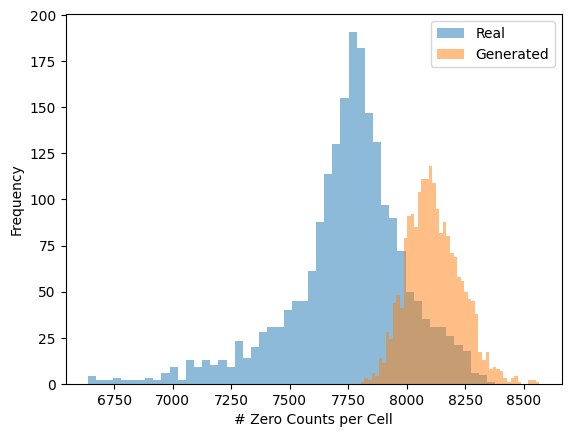

In [38]:
qual_eval_plots.sparsity_plot(test_path, gen_path)

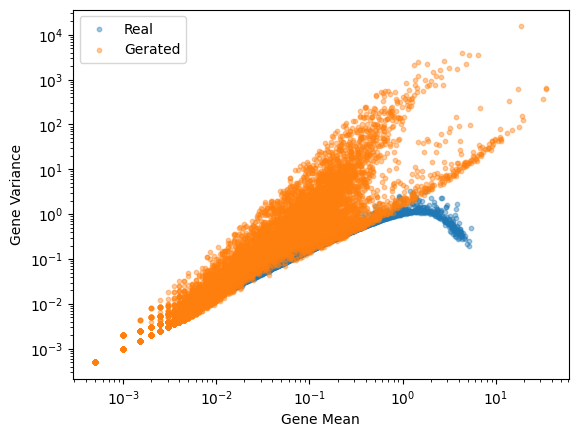

In [39]:
qual_eval_plots.overdispersion_plot(test_path, gen_path)

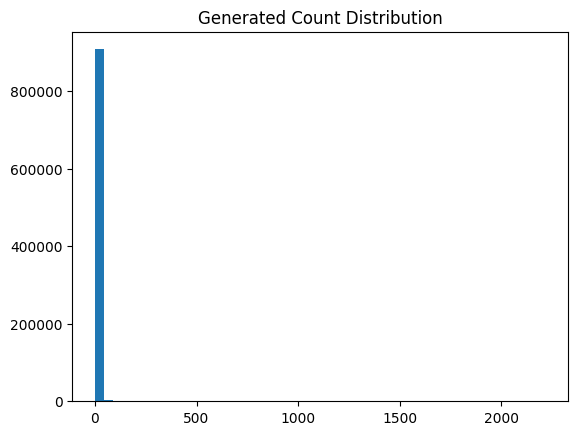

In [40]:
qual_eval_plots.discreteness_plot(test_path, gen_path)

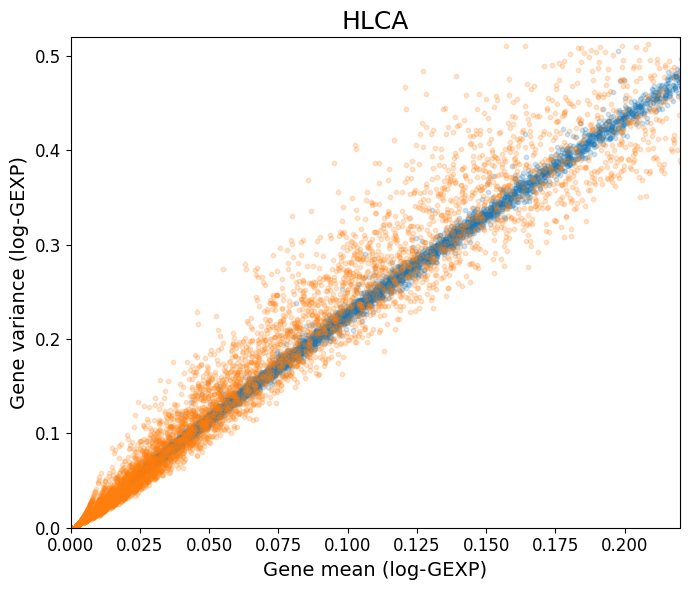

In [15]:
qual_eval_plots.hlca_plot(test_path, gen_path)

Real shape: (2110, 8573)
Generated shape: (2000, 8573)


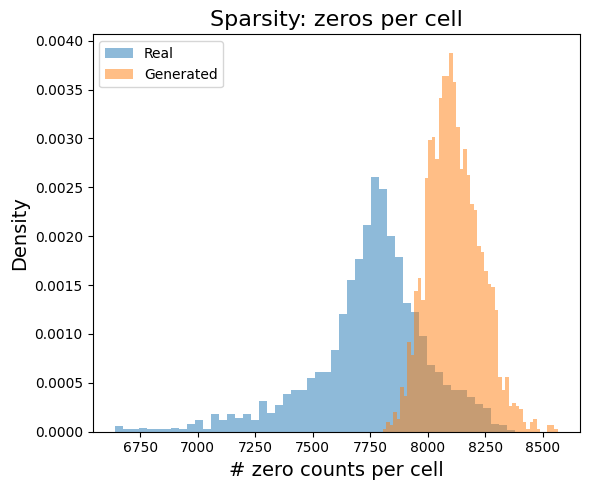

In [41]:
qual_eval_plots.sparsity_density_plot(test_path, gen_path)